In [1]:
import glob
import math
from typing import Tuple
from pprint import pprint
from tqdm import tqdm

import rasterio as rio

# Traditional imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Dask imports
import dask.array as da
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

### Load Elevation Maps Index ###

In [27]:
data_index_path = "/ds2/remote_sensing/ben-ge/ben-ge/data-index/ben-ge-train.csv" 
index_df = pd.read_csv(data_index_path)

In [28]:
index_df.head(2)

,patch_id,filename,tree_cover,shrubland,grassland,cropland,built-up,bare/sparse_vegetation,snow_and_ice,permanent_water_bodies,herbaceous_wetland,mangroves,moss_and_lichen
0,S2A_MSIL2A_20180205T100211_34_84,S2A_MSIL2A_20180205T100211_34_84_esaworldcover...,0.799375,0.000000,0.014167,0.001111,0.082917,0.000139,0.0,0.102292,0.0,0.0,0.0
1,S2A_MSIL2A_20171121T112351_25_32,S2A_MSIL2A_20171121T112351_25_32_esaworldcover...,0.202153,0.002569,0.664583,0.052708,0.076667,0.001319,0.0,0.000000,0.0,0.0,0.0


### Load Sentinel-1 Files ###

In [4]:
glo_30_dem_root_path = "/ds2/remote_sensing/ben-ge/ben-ge/glo-30_dem"
filenames = [f"{glo_30_dem_root_path}/{patch_id}_dem.tif" for patch_id in index_df["patch_id"]]

In [5]:
def read_one_image(block_id, filenames=filenames, axis=0):
    path = filenames[block_id[axis]]
    with rio.open(path) as image_file:
        img_altitude = image_file.read()
    return np.expand_dims(img_altitude[0], axis=axis)

# load the first image (assume rest are same shape/dtype)
with rio.open(filenames[0]) as image_file:
    img_altitude = image_file.read()
sample = img_altitude[0]

stack = da.map_blocks(
    read_one_image,
    dtype=sample.dtype,
    chunks=((1,) * len(filenames),  *sample.shape)
)

In [6]:
stack

dask.array<read_one_image, shape=(465856, 120, 120), dtype=int16, chunksize=(1, 120, 120), chunktype=numpy.ndarray>

### Compute Channelwise Sentinel 1 Statistics  ###

In [7]:
glo_30_dem_stats = [
    getattr(stack, stat)()
    for stat in ["min", "max", "mean", "std"]
]

glo_30_dem_stats += [da.histogram(stack, bins=2000, range=(-1000, 3000))]

### Run Computation ###

In [ ]:
with ProgressBar():
    stats_result = da.compute(*glo_30_dem_stats)

[                                        ] | 0% Completed | 411.40 ss

IOStream.flush timed out


[#################                       ] | 42% Completed | 59m 27s

In [ ]:
import pickle
with open("./glo_30_dem_stats_result.pkl", "wb") as out_file:
    pickle.dump(stats_result, out_file)

### Compute Quantiles from histogram ###

In [ ]:
def calculate_percentile_from_histogram(hist_counts, hist_bins, p=0.5):
    n = hist_counts.sum()
    quantile_index = int(p*n)
    
    # Find bin in which quantile index is placed
    cum_sum = 0
    bin_index = 0
    for i, counts in enumerate(hist_counts):
        cum_sum += counts
        # If cumulative sum exceeds quantile index stop
        if cum_sum > quantile_index:
            bin_index = i
            break

    # Calculate bin value
    bin_lower = hist_bins[i]
    bin_width = abs(hist_bins[i+1] - bin_lower)
    overstep = cum_sum - quantile_index
    
    # Divide overstep by amount of samples in the bin
    bin_value = overstep / hist_counts[bin_index] 
    return bin_lower + bin_value

In [ ]:
max_values, min_values, mean_values, std_values, histogram_values_0  = stats_result

In [ ]:
def pretty_histogram(histogram_values: Tuple[np.ndarray, np.ndarray]):
    hist_counts, hist_bins = histogram_values
    pprint({ k: calculate_percentile_from_histogram(hist_counts, hist_bins, p=k) for k in np.arange(0.25, 1.0, 0.25)})
    plt.stairs(hist_counts, hist_bins, fill=True)

In [ ]:
pretty_histogram(histogram_values_0)

In [ ]:
stats_result[:4]

In [19]:
with open("./glo_30_dem_stats_result.pkl", "rb") as in_file:
    res = pickle.load(in_file)

{0.25: 60.22580140502682, 0.5: 112.80462025861813, 0.75: 200.55268640257168}


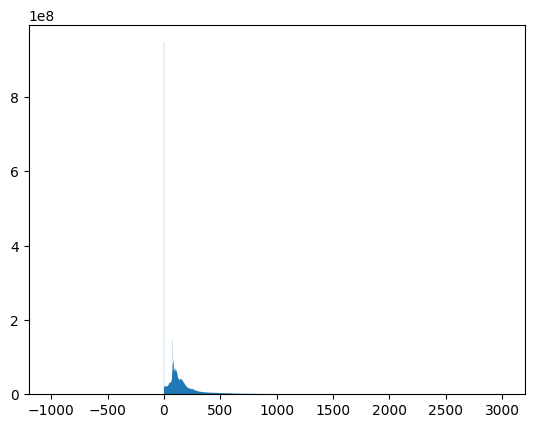

In [23]:
pretty_histogram(res[-1])

In [31]:
hist_values = res[-1]

In [50]:
hist_values_neg = (hist_values[0][450:500], hist_values[1][450:501])

{0.25: -1.2037130470015311, 0.5: -1.4691420313343542, 0.75: -1.7345710156671772}


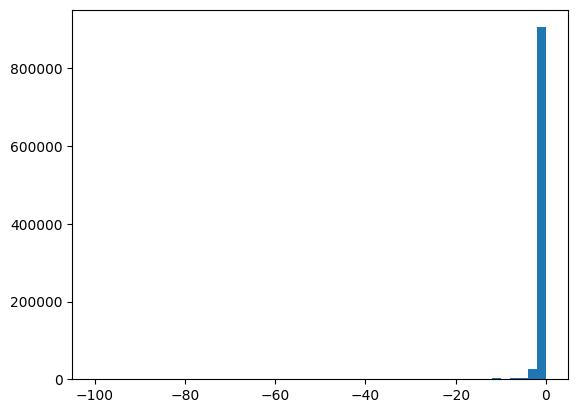

In [51]:
pretty_histogram(hist_values_neg)

In [35]:
hist_values_neg

<generator object <genexpr> at 0x7f116205bac0>

In [53]:
hist_values[0][400:500]

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      1,      4,      6,     15,     11,     10,
           12,     15,     13,     19,     19,     24,     32,     32,
           36,     45,     46,     40,     45,     39,     50,     59,
           69,     58,     53,     49,     44,     61,     38,     51,
           39,     46,     33,     54,     44,     36,     50,     44,
           39,     61,    116,    166,    157,    209,    165,    183,
          371,    482,    469,    444,    521,    724,    725,    786,
          789,    745,    777,    926,    831,   1035,    839,   1063,
         1248,   1034,    973,    933,   1214,   1770,   2171,   1925,
         2278,   3041,  26049, 905779])

In [54]:
hist_values[1][400:500]

array([-200., -198., -196., -194., -192., -190., -188., -186., -184.,
       -182., -180., -178., -176., -174., -172., -170., -168., -166.,
       -164., -162., -160., -158., -156., -154., -152., -150., -148.,
       -146., -144., -142., -140., -138., -136., -134., -132., -130.,
       -128., -126., -124., -122., -120., -118., -116., -114., -112.,
       -110., -108., -106., -104., -102., -100.,  -98.,  -96.,  -94.,
        -92.,  -90.,  -88.,  -86.,  -84.,  -82.,  -80.,  -78.,  -76.,
        -74.,  -72.,  -70.,  -68.,  -66.,  -64.,  -62.,  -60.,  -58.,
        -56.,  -54.,  -52.,  -50.,  -48.,  -46.,  -44.,  -42.,  -40.,
        -38.,  -36.,  -34.,  -32.,  -30.,  -28.,  -26.,  -24.,  -22.,
        -20.,  -18.,  -16.,  -14.,  -12.,  -10.,   -8.,   -6.,   -4.,
         -2.])

In [56]:
res

(-147,
 2619,
 176.1756328703684,
 219.73122195411094,
 (array([0, 0, 0, ..., 0, 0, 0]),
  array([-1000.,  -998.,  -996., ...,  2996.,  2998.,  3000.])))